# Melbourne Housing Market

House Prices Prediction

The data is from Kaggle and can be found [here](https://www.kaggle.com/anthonypino/melbourne-housing-market)

In [64]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from joblib import dump

# Define functions

In [2]:
def mean_encode(df: pd.DataFrame, feature: str, target: str):
    """
    df: dataframe with "feature" and "target" columns
    feature: feature to transform
    target: target variable
    """
    new_col_name = feature + "_mean"
    df_enc = (
        # select columns
        df.loc[:, [feature, target]]
        # group by feature
        .groupby(feature)
        # aggregate over feature using target mean
        .agg(tmp_name=(target, np.mean))
        # index (i.e., feature categories) as a column
        .reset_index()
        # rename the column with the aggregated means
        .rename(columns={"tmp_name":new_col_name})
    )

    # merge: add the new column with the aggregated mean from
    # "df_enc" back into "df"
    df_merged = pd.merge(df, df_enc, how="left", on=feature)

    return df_merged


def mean_encode_2(df: pd.DataFrame, feature1: str, feature2: str, target: str):
    """
    Same as "mean_encode" but with 2 features.
    df: dataframe with "feature" and "target" columns
    feature: feature to transform
    target: target variable
    """
    new_col_name = feature1 + feature2 + "_mean"
    df_enc = (
        # select columns
        df.loc[:, [feature1, feature2, target]]
        # group by feature
        .groupby([feature1, feature2])
        # aggregate over feature using target mean
        .agg(tmp_name = (target, np.mean))
        # index (i.e., feature categories) as a column
        .reset_index()
        # rename the column with the aggregated means
        .rename(columns={"tmp_name":new_col_name})
        )

    # merge: add the new column with the aggregated mean from
    # "df_enc" back into "df"
    df_merged = pd.merge(df, df_enc, how="left", on=[feature1, feature2])

    return df_merged


def convert_to_others(df: pd.DataFrame, feature: str, N_counts: int):
    """
    df: data frame
    feature: feature to transform
    N_counts: categories with less than "N_counts" counts are converted to "others" 
    """

    df_count = (
        df
        .groupby(feature)[feature]
        .value_counts()
        .reset_index()
    )

    # Select the categories with less than N_counts
    df_other = df_count.loc[df_count["count"] < N_counts, feature]

    # Name for the new column with some categories converted to "others"
    new_col_name = feature + "_others"

    # Copy original column
    df[new_col_name] = df[feature]
    # Categories with less than "N_counts" counts (this info is #
    # stored in the data frame "df_other") are set to "others"
    df.loc[df[feature].isin(df_other), [new_col_name]] = "others"

    return df


def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])


def RMSPE(y, y_pred):
     rmspe = np.sum(((y - y_pred) / y)**2) / len(y)
     return rmspe


def print_best_model_metrics(gs, X, y):
    """"
    gs: fitted GridSearch object
    X: DataFrame with features
    y: actual target
    """
    print(f"Best parameters:\n{gs.best_params_}")
    print(f"\nBest score: {gs.best_score_:.3f}")
    print(f"RMSE: {np.sqrt(-1*gs.best_score_):.3f}")
    score = gs.score(X, y)
    print(f"\nneg_mean_squared_error on the full train set: {score:.3f}")
    print(f"RMSE on the full train set: {np.sqrt(-1*score):.3f}")
    y_pred = gs.predict(X)
    print(f"\nMean squared error = {mean_squared_error(y, y_pred, squared=False):.2f}")
    print(f"Root Mean Square Percentage Error: {RMSPE(y, y_pred):.2f}")

# Load data

In [3]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)

# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_train.csv"
X_y_train = load_ds(dataset_path, filename)

print(f"Shape: {X_y_train.shape}")

Shape: (397900, 18)


In [4]:
X_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397900 entries, 0 to 397899
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date                       397900 non-null  object 
 1   Store                      397900 non-null  float64
 2   DayOfWeek                  386039 non-null  float64
 3   Sales                      397900 non-null  float64
 4   Customers                  386030 non-null  float64
 5   Open                       385880 non-null  float64
 6   Promo                      386000 non-null  float64
 7   StateHoliday               385848 non-null  object 
 8   SchoolHoliday              385817 non-null  float64
 9   StoreType                  397900 non-null  object 
 10  Assortment                 397900 non-null  object 
 11  CompetitionDistance        396864 non-null  float64
 12  CompetitionOpenSinceMonth  271565 non-null  float64
 13  CompetitionOpenSinceYear   27

# Preprocessing pipeline

In [ ]:
# From Jonathan

class MeanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.means = {}

    def fit(self, X, y=None):
        for col in self.columns:
            self.means[col] = X.groupby(col, dropna=False)['Sales'].mean().rename(col + 'Mean')
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X = X.merge(self.means[col], on=col)
        return X

In [5]:

# TransformerMixin: add method ".fit_transform()"
# BaseEstimator: add methods ".get_params()" and ".set_params()"
# We need 3 methods:
# 1) .fit()
# 2) .transform()
# 3) .fit_transform() (provided by "TransformerMixin")
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # avoid "*args" or "**kargs" in "__init__"
    def __init__(self):
        pass

    # fit is needed later for the pipilene
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Since I use MEAN ENCODING, "X" must include
        # the terget variable. Below, just before returning
        # the transformed X, the target variable is dropped.

        # Date
        Date_2 = pd.to_datetime(X["Date"], format="%Y-%m-%d")
        X["Month"] = Date_2.dt.month
        X = mean_encode(X, "Month", "Sales")
        # drop: "Date" and "Month"

        # Store
        X = mean_encode(X, "Store", "Sales")
        # drop: "Store"

        # DayOfWeek
        X = mean_encode(X, "DayOfWeek", "Sales")
        # drop: "DayOfWeek"

        # Promo (separately for each Store)
        X = mean_encode_2(X, "Promo", "Store", "Sales")
        # drop: "Promo" and "Store"

        # SchoolHoliday
        X.loc[X.SchoolHoliday=="0", :] = 0.0
        # keep: "SchoolHoliday"

        # StoreType: keep, no transformation

        # Assortment: keep, no transformation

        # Promo2: keep, no transformation

        # CompetitionDistance
        nb = 10 # number of bins
        clip_upper = 10000
        X["CD_clip"] = X["CompetitionDistance"].clip(upper=clip_upper)
        CD_clip_bins = pd.cut(
            X["CD_clip"],
            bins=nb,
            labels=[i for i in range(nb)])
        X['CD_clip_bins'] = pd.to_numeric(CD_clip_bins)
        X["CD_clip_bins_clip"] = X["CD_clip_bins"].clip(upper=clip_upper) # 
        # drop: "CompetitionDistance", "CD_clip", "CD_clip_bins"

        # Drop unused columns
        cols_to_drop = [
            "Date", "Month", "Store", "DayOfWeek", "Customers", "Open", "Promo",
            "StateHoliday", "CompetitionDistance", "CD_clip", "CD_clip_bins",
            "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceWeek",
            "Promo2SinceYear", "PromoInterval"]
        X.drop(columns=cols_to_drop, inplace=True)

        # Drop the target
        target_to_drop = ["Sales"]
        X.drop(columns=target_to_drop, inplace=True)

        return X

In [6]:
caa = CombinedAttributesAdder()
new_x = caa.fit_transform(X_y_train)
new_x.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397900 entries, 0 to 397899
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SchoolHoliday      385817 non-null  float64
 1   StoreType          397900 non-null  object 
 2   Assortment         397900 non-null  object 
 3   Promo2             397900 non-null  int64  
 4   Month_mean         397900 non-null  float64
 5   Store_mean         397900 non-null  float64
 6   DayOfWeek_mean     386039 non-null  float64
 7   PromoStore_mean    386000 non-null  float64
 8   CD_clip_bins_clip  396864 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 27.3+ MB


In [7]:
(new_x.isna().sum() / new_x.shape[0]).reset_index()

,index,0
0,SchoolHoliday,0.030367
1,StoreType,0.000000
2,Assortment,0.000000
3,Promo2,0.000000
4,Month_mean,0.000000
5,Store_mean,0.000000
6,DayOfWeek_mean,0.029809
7,PromoStore_mean,0.029907
8,CD_clip_bins_clip,0.002604


In [8]:
# Numerical pipeline
#
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
num_pipeline = Pipeline([
    # replace NA with mean
    ('imputer', SimpleImputer(strategy='mean')),
    # standardize the variables: z = (x - mean) / SD
    ('std_scaler', StandardScaler())])

In [9]:
# Categorical pipeline
#
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
cat_pipeline = Pipeline([
    # replace NA with mode
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # apply "OneHotEncoder()"
    ('one_hot', OneHotEncoder(drop='if_binary'))])



In [10]:
list_num_attribs = ["SchoolHoliday", "Promo2", "Month_mean", "Store_mean",
                    "DayOfWeek_mean", "PromoStore_mean", "CD_clip_bins_clip"]
list_cat_attribs = ["StoreType", "Assortment"]

In [11]:
# ColumnTransformer requires tuples with:
# - a name
# - a transformer
# - a list of names (or indices) of columns to which the transformer is applied

cols_transformer = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, list_num_attribs),
    # apply "cat_pipeline" to categorical columns
    ('cat', cat_pipeline, list_cat_attribs)])

In [12]:
full_pipeline = Pipeline([
    # transform/add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform numerical and categorical attributes
    ("cols_transformer", cols_transformer)])

# Linear regression

In [13]:
X_train = X_y_train # include "Sales", CombinedAttributesAdder() drops it
y_train = X_y_train.loc[:, "Sales"].copy()

## Linear regression

In [14]:
lm = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Random forest
    ("lm", LinearRegression())])

In [15]:
lm.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['SchoolHoliday',
                                                                    'Promo2',
                                                                    'Month_mean',
                                                                    'Store_mean',
                                                                    'DayOfWeek_mean',
                                                                    'PromoStore_mean',
                                                                    'CD_clip_bins_clip']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['StoreType',
                                                                    'Assortment'])]))])),
                ('lm', LinearRegression())])

In [16]:
lm.score(X_train, y_train)

0.7899802538333073

In [17]:
y_pred = lm.predict(X_train)

In [18]:
mean_squared_error(y_train, y_pred, squared=False)

1414.4274616671228

## Cross Validation

In [19]:
lm_2 = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Decision Tree (defaul parameters)
    ("lm", LinearRegression())])

In [20]:
cross_val_score(lm_2, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

array([-1411.36652748, -1397.77531321, -1401.90459745, -1394.05434212,
       -1406.99373782])

# Random Forest

In [23]:
rf = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Random forest
    ("rf", RandomForestRegressor(random_state=123))])

In [24]:
rf.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['SchoolHoliday',
                                                                    'Promo2',
                                                                    'Month_mean',
                                                                    'Store_mean',
                                                                    'DayOfWeek_mean',
                                                                    'PromoStore_mean',
                                                                    'CD_clip_bins_clip']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['StoreType',
                                                                    'Assortment'])]))])),
                ('rf', RandomForestRegressor(random_state=123))])

In [25]:
rf.score(X_train, y_train)

0.9452213719925228

In [26]:
y_pred_rf = rf.predict(X_train)

In [27]:
mean_squared_error(y_train, y_pred_rf, squared=False)

722.3641601276025

In [52]:
np.sqrt(np.sum((y_train -y_pred_rf)**2) / len(y_train))

722.3641601276025

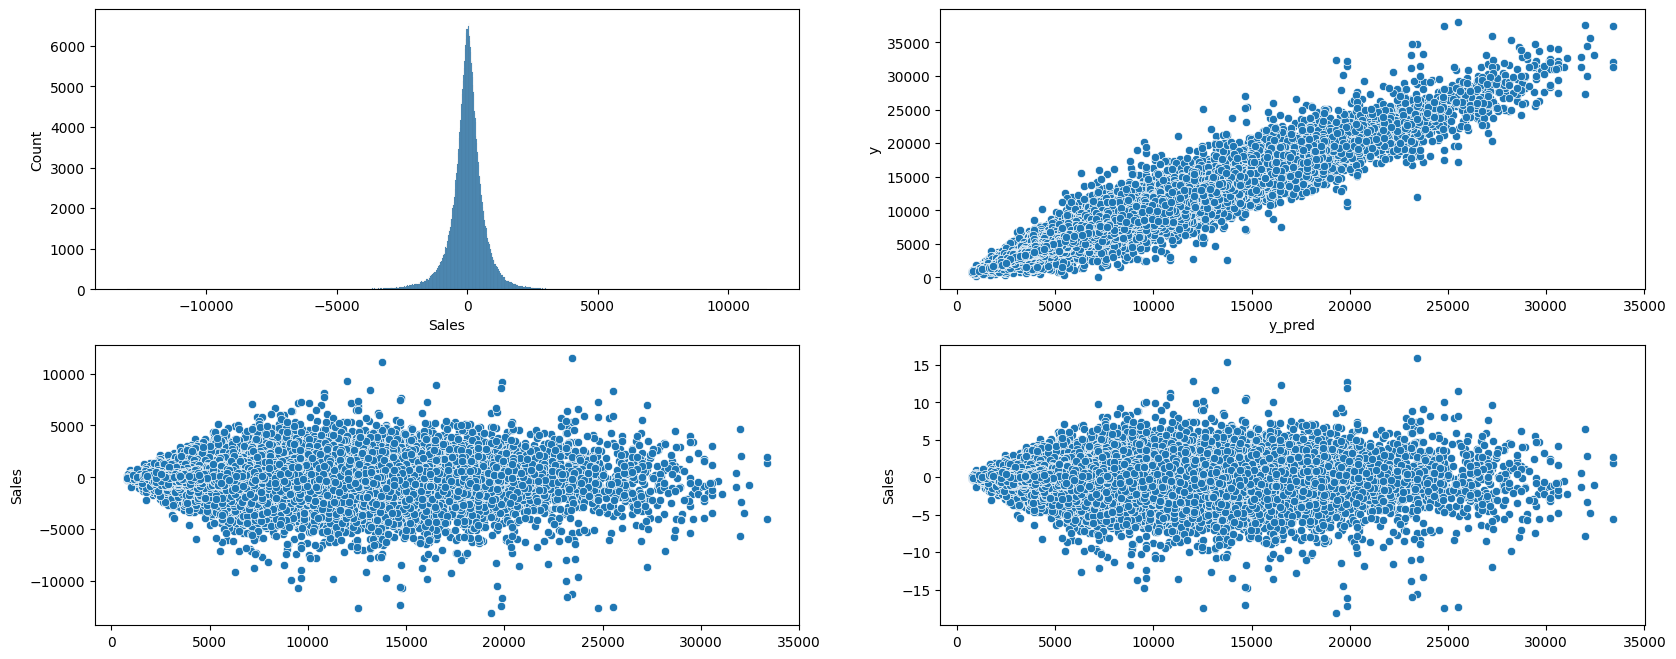

In [42]:
res = (y_pred_rf - y_train)
res_normed = (res - np.mean(res))/np.std(res)


plt.figure(figsize=(20, 8))

plt.subplot(2, 2, 1)
sns.histplot(x=res)

plt.subplot(2, 2, 2)
# sns.histplot(x=res_2)
sns.scatterplot(x=y_pred_rf, y=y_train)
plt.xlabel("y_pred")
plt.ylabel("y")

plt.subplot(2, 2, 3)
sns.scatterplot(x=y_pred_rf, y=res)

plt.subplot(2, 2, 4)
sns.scatterplot(x=y_pred_rf, y=res_normed)

plt.show()

## Cross validation

In [53]:
rf_2 = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Decision Tree (defaul parameters)
    ("rf", RandomForestRegressor(random_state=123))])

In [54]:
cross_val_score(rf_2, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

array([-1228.18646738, -1207.12353293, -1249.64435628, -1188.27171939,
       -1195.84940199])

## Grid Search 1

In [67]:
rf_3 = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Decision Tree (defaul parameters)
    ("rf", RandomForestRegressor(random_state=123))])

In [62]:
list(rf_3["rf"].get_params().keys())

['bootstrap',
 'ccp_alpha',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'max_samples',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']

In [68]:
param_grid = {
    "rf__n_estimators": [50, 100],
    "rf__max_depth": [3, 5, 10],
    "rf__min_samples_leaf": [20, 50]}

rf_gs = GridSearchCV(
    estimator=rf_3,
    param_grid=param_grid,
    cv=5, # train across 5 folds
    scoring='neg_mean_squared_error',
    verbose=1)

The following fit takes about 15 minutes

In [69]:
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        Pipeline(steps=[('attribs_adder',
                                                         CombinedAttributesAdder()),
                                                        ('cols_transformer',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('std_scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['SchoolHoliday',
                                                                                           'Promo2',
                                                                                           'Month_mean',
                                                                                           'Store_mean',
                                                                                           'DayOfWeek_mean',
                                                                                           'PromoStore_mean',
                                                                                           'CD_cli...ip']),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                          ('one_hot',
                                                                                                           OneHotEncoder(drop='if_binary'))]),
                                                                                          ['StoreType',
                                                                                           'Assortment'])]))])),
                                       ('rf',
                                        RandomForestRegressor(random_state=123))]),
             param_grid={'rf__max_depth': [3, 5, 10],
                         'rf__min_samples_leaf': [20, 50],
                         'rf__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [90]:
print_best_model_metrics(rf_gs, X_train, y_train)

Best parameters:
{'rf__max_depth': 10, 'rf__min_samples_leaf': 20, 'rf__n_estimators': 100}

Best score: -1480596.554
RMSE: 1216.798

neg_mean_squared_error on the full train set: -1384667.634
RMSE on the full train set: 1176.719

Mean squared error = 1176.72
Root Mean Square Percentage Error: 0.03


Best parameters:
- rf__max_depth: 10
- rf__min_samples_leaf: 20
- rf__n_estimators: 100

## Grid Search 2

In [94]:
rf_4 = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Decision Tree (defaul parameters)
    ("rf", RandomForestRegressor(random_state=123))])

param_grid = {
    "rf__n_estimators": [100, 150],
    "rf__max_depth": [10, 15, 20],
    "rf__min_samples_leaf": [15, 20, 25]}

rf_gs_2 = GridSearchCV(
    estimator=rf_4,
    param_grid=param_grid,
    cv=5, # train across 5 folds
    scoring='neg_mean_squared_error',
    verbose=2)

The following fit takes about 15 minutes

In [95]:
rf_gs_2.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END rf__max_depth=10, rf__min_samples_leaf=15, rf__n_estimators=100; total time=  25.8s
[CV] END rf__max_depth=10, rf__min_samples_leaf=15, rf__n_estimators=100; total time=  25.2s
[CV] END rf__max_depth=10, rf__min_samples_leaf=15, rf__n_estimators=100; total time=  25.5s
[CV] END rf__max_depth=10, rf__min_samples_leaf=15, rf__n_estimators=100; total time=  25.7s
[CV] END rf__max_depth=10, rf__min_samples_leaf=15, rf__n_estimators=100; total time=  25.3s
[CV] END rf__max_depth=10, rf__min_samples_leaf=15, rf__n_estimators=150; total time=  38.7s
[CV] END rf__max_depth=10, rf__min_samples_leaf=15, rf__n_estimators=150; total time=  38.9s
[CV] END rf__max_depth=10, rf__min_samples_leaf=15, rf__n_estimators=150; total time=  36.9s
[CV] END rf__max_depth=10, rf__min_samples_leaf=15, rf__n_estimators=150; total time=  37.5s
[CV] END rf__max_depth=10, rf__min_samples_leaf=15, rf__n_estimators=150; total time=  37.3s
[CV] END 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        Pipeline(steps=[('attribs_adder',
                                                         CombinedAttributesAdder()),
                                                        ('cols_transformer',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('std_scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['SchoolHoliday',
                                                                                           'Promo2',
                                                                                           'Month_mean',
                                                                                           'Store_mean',
                                                                                           'DayOfWeek_mean',
                                                                                           'PromoStore_mean',
                                                                                           'CD_cli...
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                          ('one_hot',
                                                                                                           OneHotEncoder(drop='if_binary'))]),
                                                                                          ['StoreType',
                                                                                           'Assortment'])]))])),
                                       ('rf',
                                        RandomForestRegressor(random_state=123))]),
             param_grid={'rf__max_depth': [10, 15, 20],
                         'rf__min_samples_leaf': [15, 20, 25],
                         'rf__n_estimators': [100, 150]},
             scoring='neg_mean_squared_error', verbose=2)

In [96]:
print_best_model_metrics(rf_gs_2, X_train, y_train)

Best parameters:
{'rf__max_depth': 20, 'rf__min_samples_leaf': 15, 'rf__n_estimators': 150}

Best score: -1368298.680
RMSE: 1169.743

neg_mean_squared_error on the full train set: -969492.953
RMSE on the full train set: 984.628

Mean squared error = 984.63
Root Mean Square Percentage Error: 0.02


Best parameters:
- rf__max_depth: 20
- rf__min_samples_leaf: 15
- rf__n_estimators: 150

# Save the model

In [106]:
dump(rf_gs_2, "models/GridSearch_2")

['models/GridSearch_2']

In [101]:
import pickle

In [105]:
# open a file, where you ant to store the data
file = open('models/GridSearch_2aaaa', 'wb')

# dump information to that file
pickle.dump(rf_gs_2.best_estimator_, file)

# close the file
file.close()

In [103]:
rf_gs_2

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        Pipeline(steps=[('attribs_adder',
                                                         CombinedAttributesAdder()),
                                                        ('cols_transformer',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('std_scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['SchoolHoliday',
                                                                                           'Promo2',
                                                                                           'Month_mean',
                                                                                           'Store_mean',
                                                                                           'DayOfWeek_mean',
                                                                                           'PromoStore_mean',
                                                                                           'CD_cli...
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                          ('one_hot',
                                                                                                           OneHotEncoder(drop='if_binary'))]),
                                                                                          ['StoreType',
                                                                                           'Assortment'])]))])),
                                       ('rf',
                                        RandomForestRegressor(random_state=123))]),
             param_grid={'rf__max_depth': [10, 15, 20],
                         'rf__min_samples_leaf': [15, 20, 25],
                         'rf__n_estimators': [100, 150]},
             scoring='neg_mean_squared_error', verbose=2)